<a href="https://colab.research.google.com/github/ehager77/intro_to_ai/blob/master/intro_to_ai_hw3_ehager_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [899]:
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
import numpy as np
import pandas as pd
import os
import seaborn as sns
from google.colab import drive
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [900]:
print(tf.__version__)

2.3.0


In [901]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [902]:
# defining global variable path
# Location of my dataset on My Google Drive
root = '/content/drive/My Drive/95891-F20-hw3-data'
data = '/content/drive/My Drive/95891-F20-hw3-data/images'

In [903]:
IMG_SIZE = (224, 224)
BATCH_SIZE=32

In [904]:
train_dataset = image_dataset_from_directory(data+'/train',
                                             validation_split=.1,
                                             subset='training',
                                             seed = 123,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 1000 files belonging to 10 classes.
Using 900 files for training.


In [905]:
validation_dataset = image_dataset_from_directory(data+'/train',
                                             validation_split=.1,
                                             subset='validation',
                                             seed = 123,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 1000 files belonging to 10 classes.
Using 100 files for validation.


In [906]:
test_dataset = image_dataset_from_directory(data+'/test',
                                             shuffle=False,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 1848 files belonging to 10 classes.


In [907]:
class_names = train_dataset.class_names
NUM_CLASSES = len(class_names)
print('Number of classes:', NUM_CLASSES)
print(class_names)

Number of classes: 10
['airport_inside', 'bathroom', 'buffet', 'classroom', 'dining_room', 'garage', 'jewelleryshop', 'meeting_room', 'restaurant', 'subway']


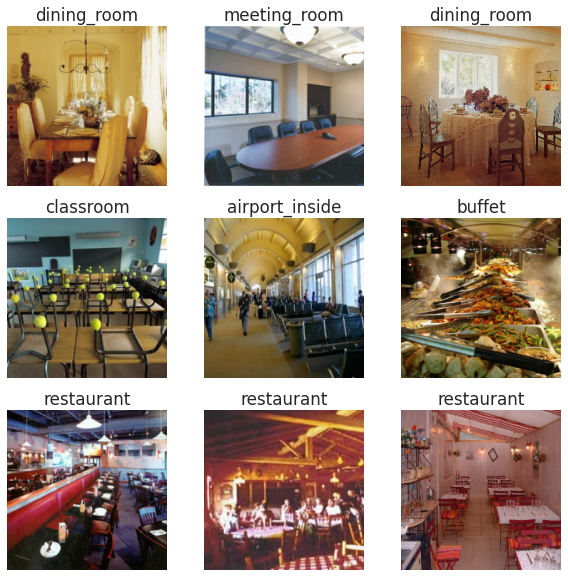

In [908]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [909]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [910]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(100).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [911]:
# Create data augmentation layer
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(224, 
                                                              224,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

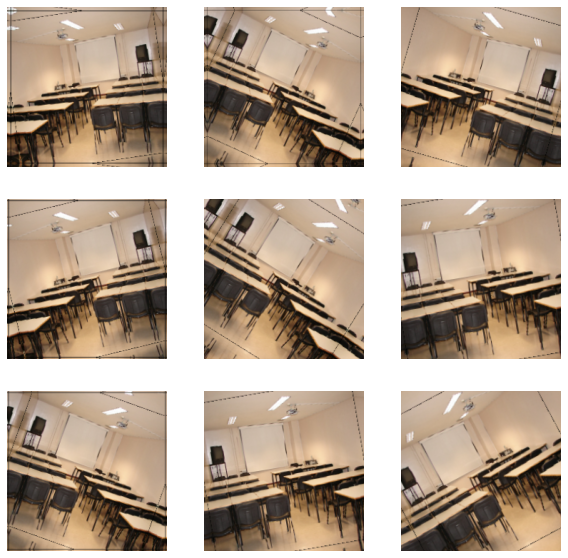

In [912]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [913]:
# Create the base model from the pre-trained model MOBILENETV2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
# Freeze bottom layers
base_model.trainable = False

In [914]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [915]:
# CREATE RESCALING LAYER
preprocess_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [916]:
# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.30)(x)# Regularize with dropout
x = keras.layers.Flatten()(x)
# Hidden Layers
for num in np.geomspace(512, 16, endpoint=False, num=5):
  print(num)
  x = keras.layers.Dense(num, activation='relu')(x)
# Prediction Layer
outputs = keras.layers.Dense(NUM_CLASSES)(x)
model = keras.Model(inputs, outputs)

model.summary()

512.0000000000001
256.0
127.99999999999999
64.00000000000001
32.00000000000001
Model: "functional_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_59 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_23 (Sequential)   (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling_20 (Rescaling)     (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_34  (None, 1280)              0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 1280)              0         
________________________________________

In [917]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [918]:
len(model.trainable_variables)

12

In [919]:
initial_epochs = 30

loss0, accuracy0 = model.evaluate(validation_dataset)

4/4 [==============================] - 0s 29ms/step - loss: 2.3056 - accuracy: 0.1200


In [920]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.31
initial accuracy: 0.12


In [921]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/30
29/29 [==============================] - 1s 51ms/step - loss: 2.2498 - accuracy: 0.1667 - val_loss: 2.1644 - val_accuracy: 0.2900
Epoch 2/30
29/29 [==============================] - 1s 49ms/step - loss: 2.0579 - accuracy: 0.3033 - val_loss: 1.9335 - val_accuracy: 0.4500
Epoch 3/30
29/29 [==============================] - 1s 50ms/step - loss: 1.7490 - accuracy: 0.4311 - val_loss: 1.5549 - val_accuracy: 0.5500
Epoch 4/30
29/29 [==============================] - 1s 50ms/step - loss: 1.3998 - accuracy: 0.5856 - val_loss: 1.1774 - val_accuracy: 0.6800
Epoch 5/30
29/29 [==============================] - 1s 50ms/step - loss: 1.1242 - accuracy: 0.6478 - val_loss: 1.0576 - val_accuracy: 0.6800
Epoch 6/30
29/29 [==============================] - 1s 50ms/step - loss: 0.9471 - accuracy: 0.7189 - val_loss: 0.8999 - val_accuracy: 0.6900
Epoch 7/30
29/29 [==============================] - 1s 49ms/step - loss: 0.8409 - accuracy: 0.7267 - val_loss: 0.8854 - val_accuracy: 0.6800
Epoch 8/30
29

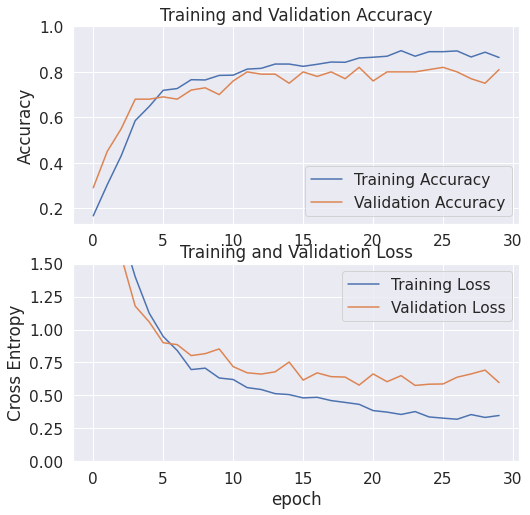

In [922]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [923]:
# Unfreeze bottom layers
base_model.trainable = True

In [924]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 130

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [925]:
model.compile(optimizer=tf.keras.optimizers.Adam(base_learning_rate/10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [926]:
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 30/60
29/29 [==============================] - 2s 81ms/step - loss: 0.2852 - accuracy: 0.8933 - val_loss: 0.6015 - val_accuracy: 0.8100
Epoch 31/60
29/29 [==============================] - 2s 57ms/step - loss: 0.2953 - accuracy: 0.8933 - val_loss: 0.5871 - val_accuracy: 0.8300
Epoch 32/60
29/29 [==============================] - 2s 57ms/step - loss: 0.2737 - accuracy: 0.8956 - val_loss: 0.5722 - val_accuracy: 0.8000
Epoch 33/60
29/29 [==============================] - 2s 57ms/step - loss: 0.2582 - accuracy: 0.9022 - val_loss: 0.5972 - val_accuracy: 0.8100
Epoch 34/60
29/29 [==============================] - 2s 57ms/step - loss: 0.2373 - accuracy: 0.9156 - val_loss: 0.6272 - val_accuracy: 0.8200
Epoch 35/60
29/29 [==============================] - 2s 57ms/step - loss: 0.2473 - accuracy: 0.9122 - val_loss: 0.5623 - val_accuracy: 0.8000
Epoch 36/60
29/29 [==============================] - 2s 57ms/step - loss: 0.2392 - accuracy: 0.9222 - val_loss: 0.5760 - val_accuracy: 0.8200
Epoch 

In [927]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

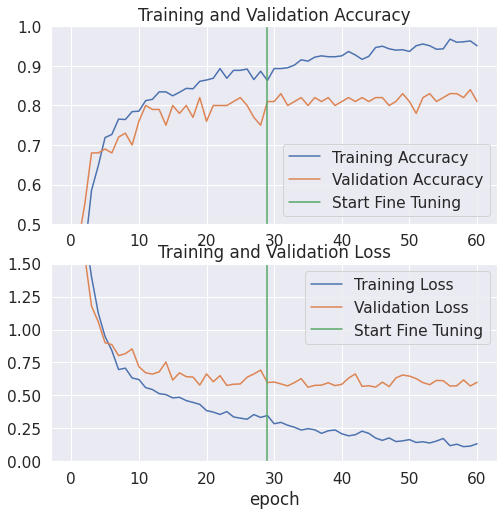

In [928]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.5])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [929]:
# 1. Accuracy of model on test data
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', str(round(accuracy, 2)))

58/58 [==============================] - 12s 199ms/step - loss: 0.8783 - accuracy: 0.7284
Test accuracy : 0.73


In [930]:
test_image_batch, test_label_batch = next(iter(test_dataset))
true_label_ids = np.argmax(test_label_batch, axis=-1)
print("Test batch shape:", test_image_batch.shape)

Test batch shape: (32, 224, 224, 3)


In [931]:
# Checking if models working by predicting on first few elements
tf_model_predictions = model.predict(test_image_batch)
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe.columns = class_names
print("Prediction results for the first elements")
tf_pred_dataframe.head()

Prediction results for the first elements


,airport_inside,bathroom,buffet,classroom,dining_room,garage,jewelleryshop,meeting_room,restaurant,subway
0,8.341739,-2.933976,-1.105312,2.266147,-1.821627,8.031246,8.645457,2.727101,4.394300,7.326210
1,13.030663,-3.518898,5.146537,2.121174,0.624445,4.313673,3.603607,0.259236,-0.146085,6.930919
2,12.380323,-2.772239,-0.178577,0.866667,0.852222,1.403191,4.061399,2.162699,2.816896,11.405807
3,12.142158,-4.766253,0.369996,0.511781,-1.787540,4.038190,4.551176,3.148812,2.754150,15.846479
4,14.235420,-5.745798,-0.527359,0.758605,-0.599909,3.651703,7.739789,3.391885,4.757651,13.810452


In [932]:
# Checking to see what preductions and test_label_batch returns
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
print(predicted_ids)
test_label_arr = test_label_batch.numpy()
print(test_label_arr)

[6 0 0 9 0 7 0 0 0 4 0 0 0 0 9 9 0 0 9 0 7 0 0 0 0 0 9 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


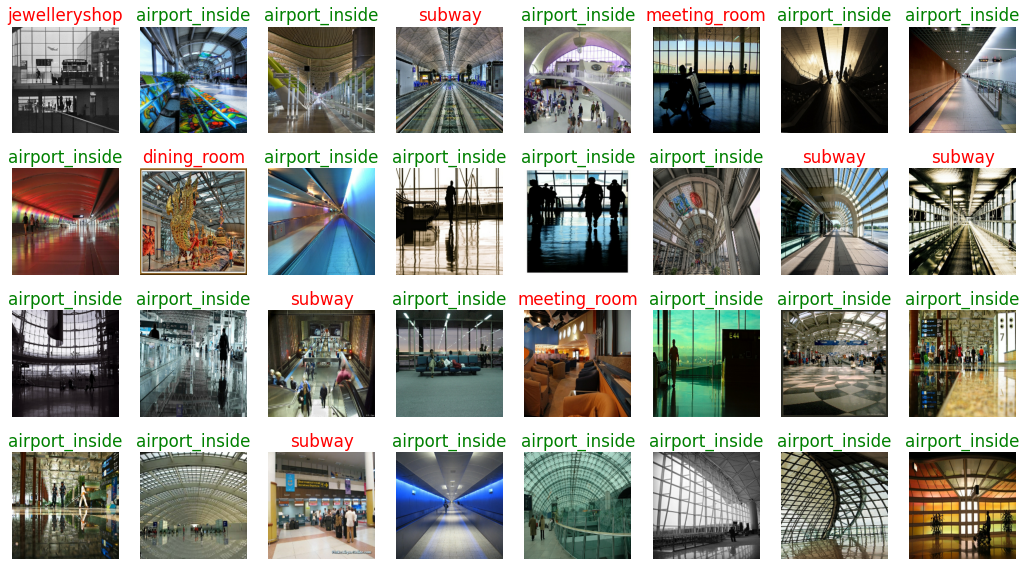

In [933]:
# Visualizing correct and incorrect predicitions
plt.figure(figsize=(18, 10))
for i in range(BATCH_SIZE):
  ax = plt.subplot(4, 8, i + 1)
  plt.imshow(test_image_batch[i].numpy().astype("uint8"))
  if test_label_arr[i] == predicted_ids[i]:
    color = 'green'
  else:
    color = 'red'
  plt.title(class_names[predicted_ids[i]], color = color)
  plt.axis("off")

In [934]:
# Getting all predicitions
predictions = model.predict(test_dataset)
pred_dataframe = pd.DataFrame(predictions)
pred_dataframe.columns = class_names
print("Prediction results for the all elements")
pred_dataframe

Prediction results for the all elements


,airport_inside,bathroom,buffet,classroom,dining_room,garage,jewelleryshop,meeting_room,restaurant,subway
0,8.341739,-2.933976,-1.105312,2.266147,-1.821627,8.031246,8.645457,2.727101,4.394300,7.326210
1,13.030663,-3.518898,5.146537,2.121174,0.624445,4.313673,3.603607,0.259236,-0.146085,6.930919
2,12.380323,-2.772239,-0.178577,0.866667,0.852222,1.403191,4.061399,2.162699,2.816896,11.405807
3,12.142158,-4.766253,0.369996,0.511781,-1.787540,4.038190,4.551176,3.148812,2.754150,15.846479
4,14.235420,-5.745798,-0.527359,0.758605,-0.599909,3.651703,7.739789,3.391885,4.757651,13.810452
...,...,...,...,...,...,...,...,...,...,...
1843,11.296441,-4.203804,0.159104,-2.820345,-1.664279,2.528894,8.244304,3.743027,3.868702,16.401161
1844,10.988106,-6.047354,0.954463,0.146515,-2.125970,3.609231,6.180554,3.620647,2.547797,17.386881
1845,10.289634,-4.309387,0.554356,3.663589,-1.694957,3.982634,3.062489,4.787141,1.874442,17.879496
1846,12.121872,-6.410804,-0.059967,-0.319934,-4.022923,4.798281,9.143199,5.891646,2.053590,16.682043


In [935]:
# Formatting data to plot in confusion matrix
predicted_ids = np.argmax(predictions, axis=-1)
predicted_ids = list(predicted_ids)
# print('Predicted labels:', predicted_ids)
# print('Number of labels in list:', len(predicted_ids))

In [936]:
test_ds = test_dataset.take(len(test_dataset))
test_labels = []
for image, label in test_ds:  # example is (image, label)
  for l in label.numpy():
    test_labels.append(l)
# print('Test labels:', test_labels)
# print('Number of labels in list:', len(test_labels))

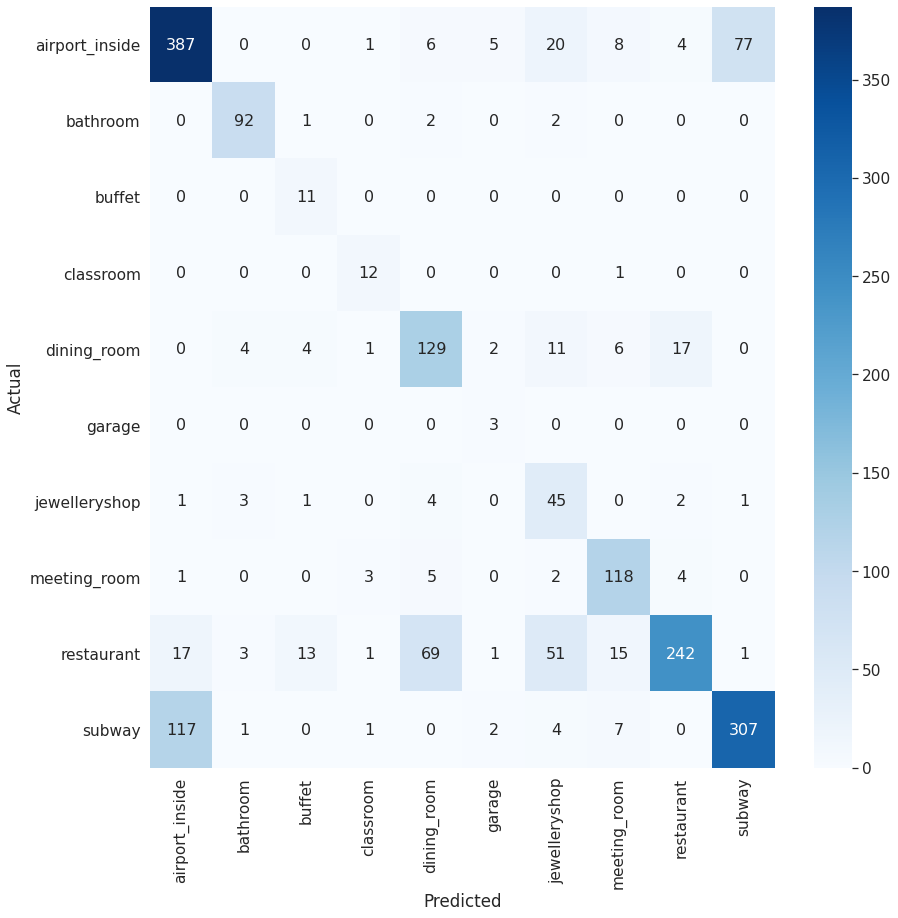

In [937]:
# 2. Confusion Matrix with raw data values
y_true = test_labels
y_pred = predicted_ids
data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=class_names, index = class_names)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (14,14))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='g')# font size


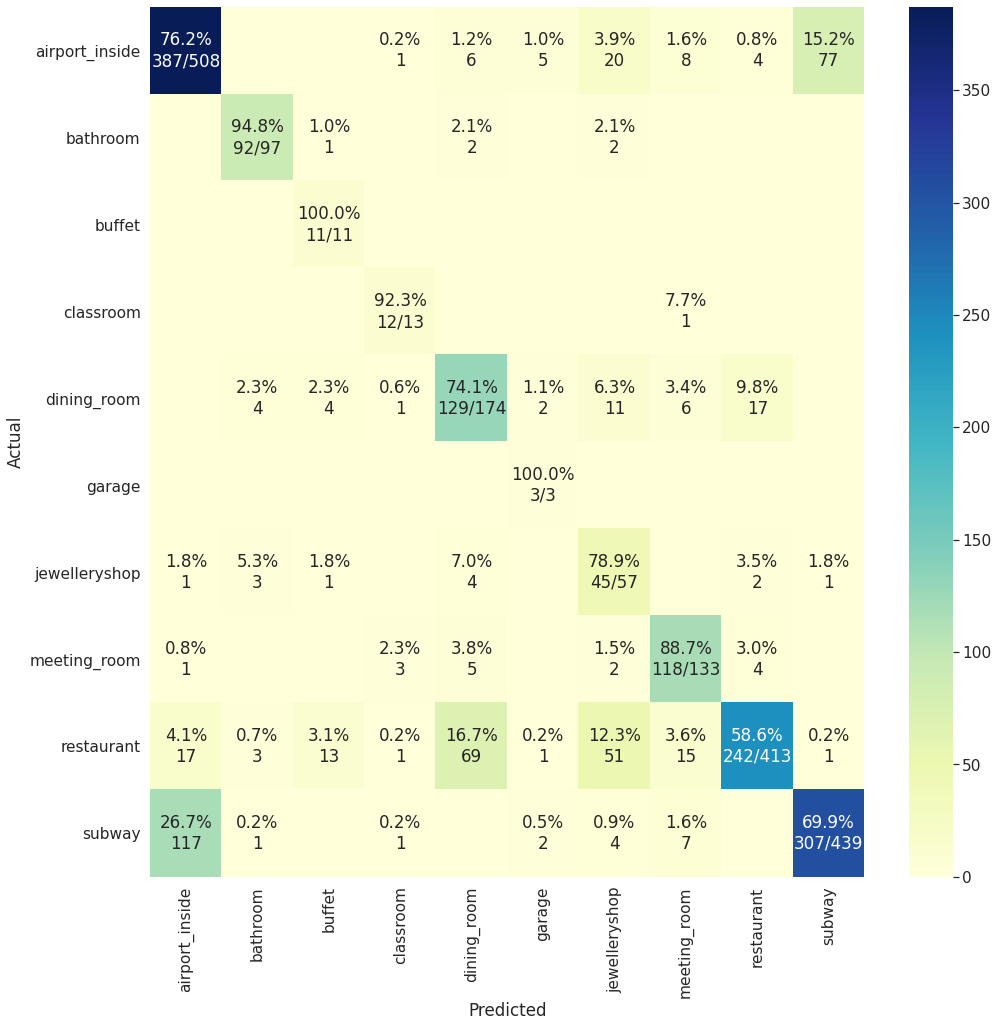

In [938]:
# 3. Normalized Confusion Matrix with showing accuracy per category
# 4. Most accurately predicted categories are both buffet and garage with 100% accuracy
# 5. Least accurately predicted category is restaurant at roughly 59% accuracy and it's most often confused with dining room about 17% of the time.
def plot_cm(y_true, y_pred, figsize=(16,16)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    
plot_cm(y_true, y_pred)

In [939]:
# Calculating precision and recall scores per category and storing them in pandas dataframe to for visualization
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_true, y_pred, average=None)
recall_sc = recall_score(y_true, y_pred, average=None)
df = pd.DataFrame(data=precision, index=class_names, columns=['Precision Score'])
df['Recall Score'] = recall_sc
print(df)

                Precision Score  Recall Score
airport_inside         0.739962      0.761811
bathroom               0.893204      0.948454
buffet                 0.366667      1.000000
classroom              0.631579      0.923077
dining_room            0.600000      0.741379
garage                 0.230769      1.000000
jewelleryshop          0.333333      0.789474
meeting_room           0.761290      0.887218
restaurant             0.899628      0.585956
subway                 0.795337      0.699317


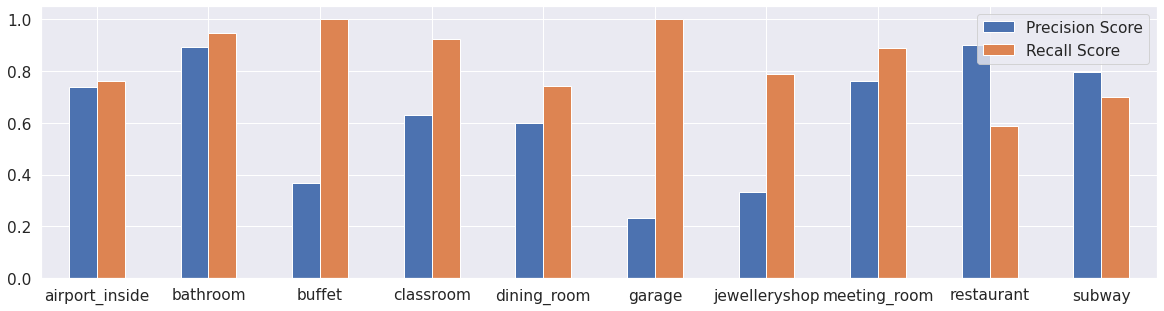

In [940]:
# 6. Plotting grouped bar chart with precision and recall scores per category
ax = df.plot.bar(rot=0, figsize=(20,5))